In [1]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import zipfile

import cv2
import os
import glob
import gc

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
#DOWNLOAD DEL DATASET
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2023-03-17 10:02:31--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.208
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  16.0MB/s    in 95s     

2023-03-17 10:04:07 (14.5 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [3]:
#UNZIP DEL DATASET
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [4]:
#FUNZIONE PER CARICARE IN MEMORIA LE IMMAGINI
def read_images(img_dir, xdim, ydim, nmax=50000) :
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>=nmax : break
            img = cv2.imread(f1) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = cv2.resize(img, (xdim,ydim))
            X.append(np.array(img)) 
            n=n+1
        print(n,' images lues')
    X = np.array(X)
    gc.collect() 
    return X

In [5]:
#CARICO IN MEMORIA 100000 IMMAGINI
X= read_images("data_faces", 64, 64, 100000)

img_align_celeba
100000  images lues


In [6]:
#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test = train_test_split(X,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val = train_test_split(X_train, 
    test_size=0.1)

#MODIFICA DI COME VENGONO SALVATE LE IMMAGINI IN MEMORIA
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [7]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(72000, 64, 64, 3)

In [8]:
#DIMENSIONI DEL TEST SET
X_test.shape

(20000, 64, 64, 3)

In [9]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(8000, 64, 64, 3)

In [10]:
X_train_1=X_train[36000:]
X_train_2=X_train[:36000]

In [11]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TRAINING SET
noise_factor = 0.2

X_train_1_noisy = random_noise(X_train_1, mode="s&p",clip=True, amount=noise_factor)
X_train_2_noisy = random_noise(X_train_2, mode="s&p",clip=True, amount=noise_factor)
X_train_noisy=np.concatenate((X_train_2_noisy, X_train_1_noisy), axis=0)

In [12]:
#PULIZIA MEMORIA
X_train_1=np.delete
X_train_2=np.delete
X_train_1_noisy=np.delete
X_train_2_noisy=np.delete

In [13]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI DEL TEST SET E DEL VALIDATION SET
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

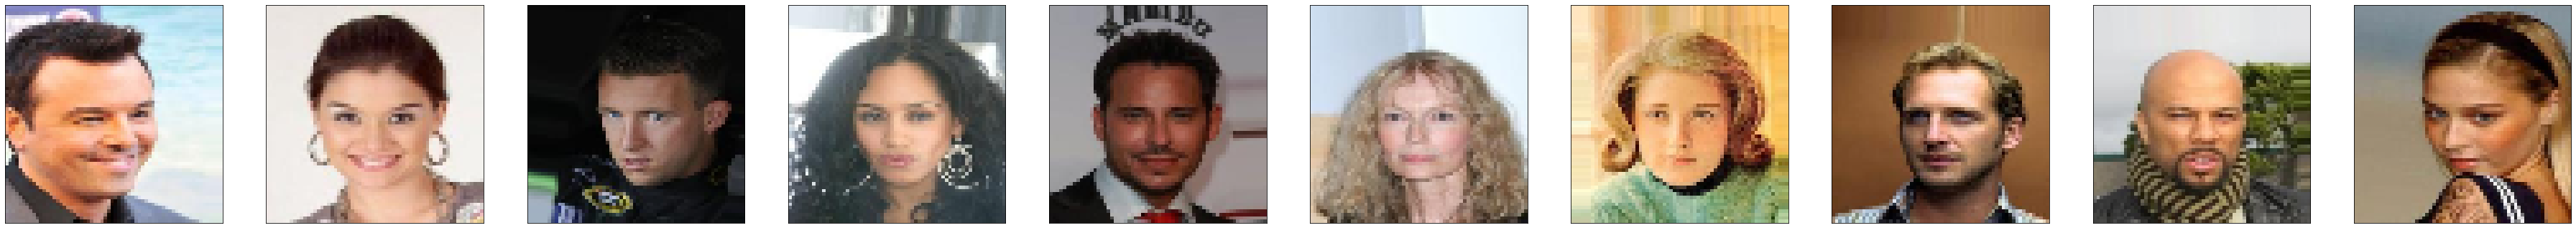

In [14]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

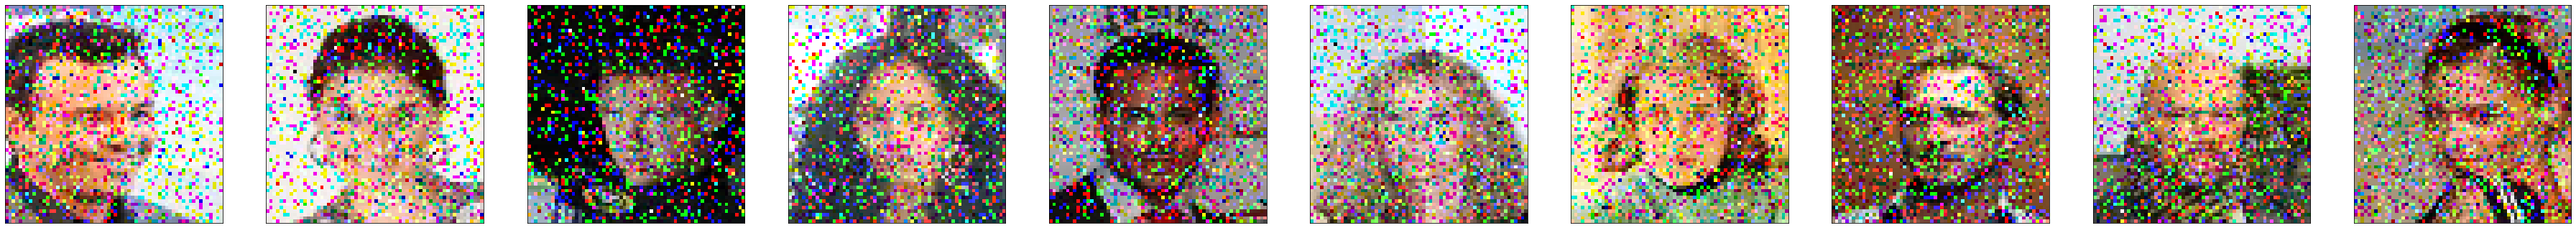

In [15]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, Add
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
     

def create_model():
    tf.keras.backend.clear_session()

    input_0 = Input(shape=(64,64,3), name="input_layer")
    conv_layer_1 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_1")(input_0)
    conv_layer_2 = Conv2D(filters=256, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    conv_layer_3 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_3")(conv_layer_2)
    conv_layer_4 = Conv2D(filters=256, kernel_size=3, padding='same', name="conv_4")(conv_layer_3)
    conv_layer_5 = Conv2D(filters=128, kernel_size=3, padding='same', name="conv_5")(conv_layer_4)

    deconv_layer_5 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_5")(conv_layer_5)
    deconv_layer_5 = Add(name="add_1")([conv_layer_4, deconv_layer_5])
    deconv_layer_4 = Conv2DTranspose(filters=256, kernel_size=2, padding='same', name="deconv_4")(deconv_layer_5)
    deconv_layer_3 = Conv2DTranspose(filters=256, kernel_size=3, padding='same', name="deconv_3")(deconv_layer_4)
    deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=3, padding='same', name="deconv_2")(deconv_layer_3)
    deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=3, padding='same', name="deconv_1")(deconv_layer_2)
    out = Add(name="add_3")([input_0, deconv_layer_1])

    model = Model(inputs=[input_0], outputs=[out])
    return model
     

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 64, 64, 256)  3328        ['input_layer[0][0]']            
                                                                                                  
 conv_2 (Conv2D)                (None, 64, 64, 256)  262400      ['conv_1[0][0]']                 
                                                                                                  
 conv_3 (Conv2D)                (None, 64, 64, 256)  590080      ['conv_2[0][0]']                 
                                                                                              

In [17]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))

In [18]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
4500/4500 [==============================] - 865s 189ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 2/100
4500/4500 [==============================] - 850s 189ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 3/100
4500/4500 [==============================] - 860s 191ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 4/100
4500/4500 [==============================] - 850s 189ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 5/100
4500/4500 [==============================] - 850s 189ms/step - loss: 0.0067 - val_loss: 0.0067


In [19]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

625/625 [==============================] - 78s 122ms/step


In [20]:
predict.shape

(20000, 64, 64, 3)

In [21]:
n=10

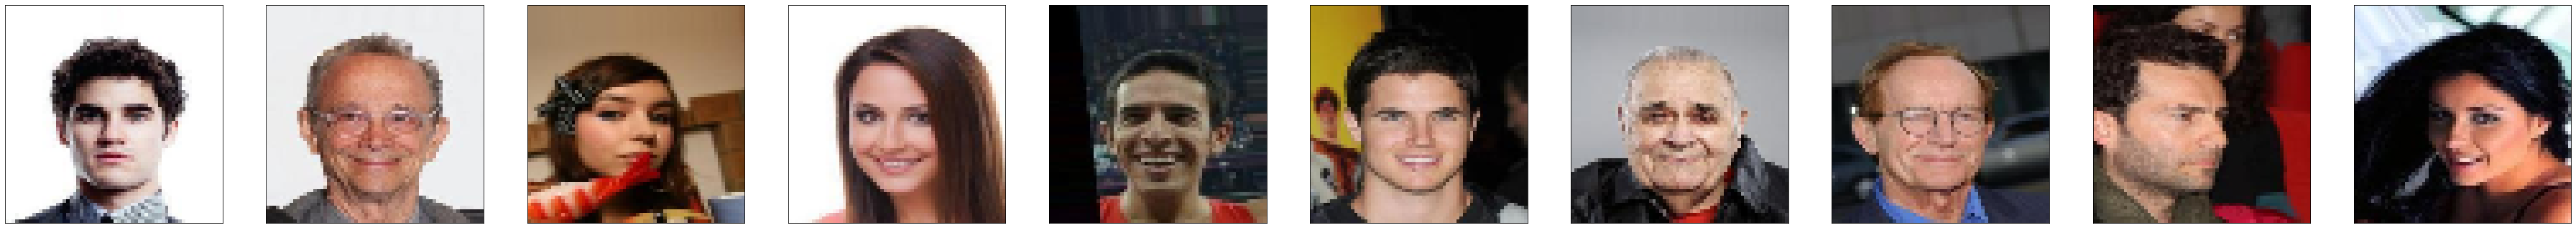

In [22]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

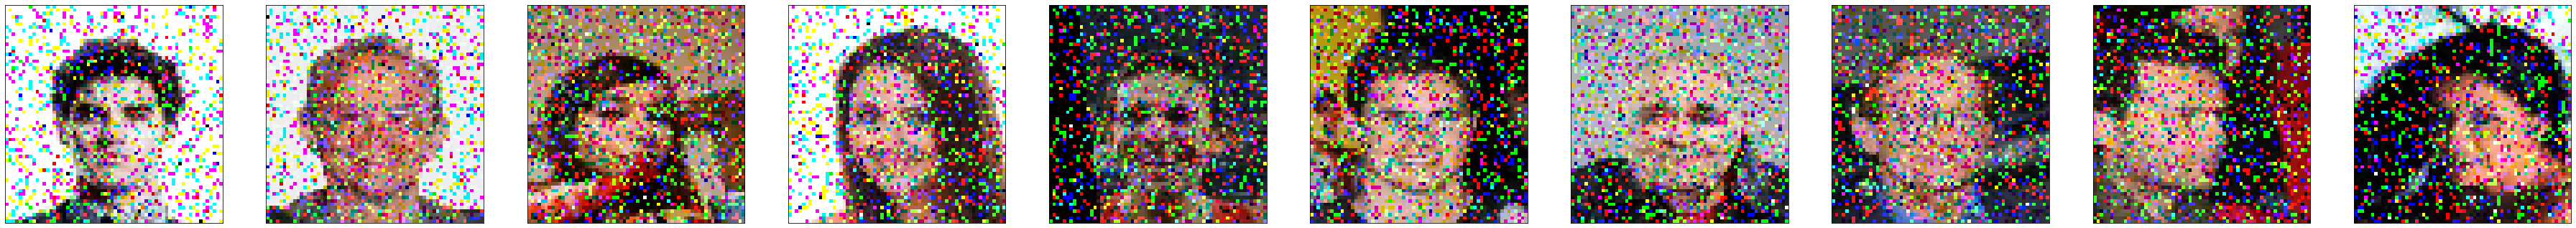

In [23]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

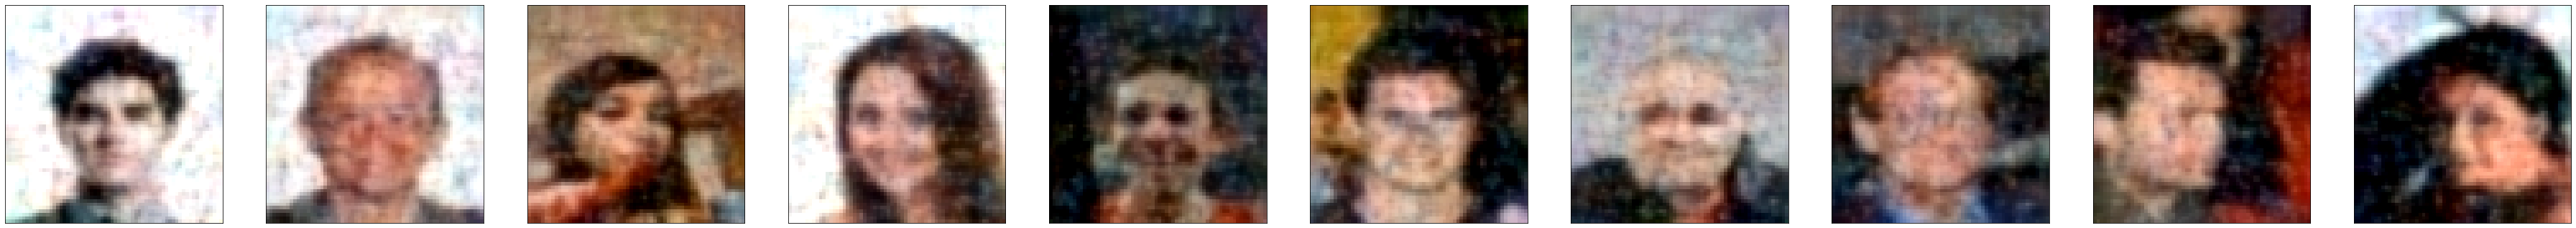

In [24]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.006676173
Mean Absolute Error: 0.061176915
Root Mean Squared Error: 0.08170785


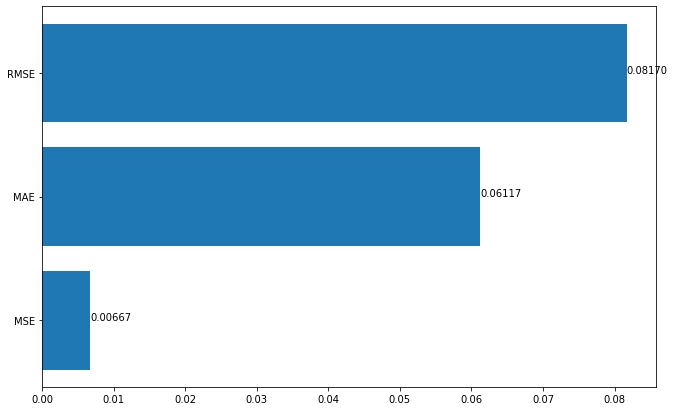

In [26]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()